In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
N = 25000

real_users = ['ivanov', 'petrova', 'smith', 'lee', 'jones', 'garcia', 'zhang', 'kumar', 'kim', 'hansen', 'sidorov', 'miller', 'chung', 'li', 'andrievskiy', 'volkova']
services = ['backup_service', 'etl_service', 'api_service', 'cleaner_service', 'monitoring_service', 'report_service', 'archive_service', 'email_service']
query_types = ['SELECT', 'INSERT', 'UPDATE', 'DELETE']
objects = ['table_a', 'table_b', 'table_c', 'table_d', 'table_e']
hours = np.arange(0,24)
days = np.arange(0,7)  # 0-пн ... 6-вс

data = []
for _ in range(N):
    if np.random.rand() < 0.7:
        user = np.random.choice(real_users)
        is_service = 0
    else:
        user = np.random.choice(services)
        is_service = 1
    query_type = np.random.choice(query_types, p=[0.5, 0.25, 0.2, 0.05])
    hour = np.random.choice(hours)
    day_of_week = np.random.choice(days)
    if hour < 6:
        hour_group = 'night'
    elif hour < 12:
        hour_group = 'morning'
    elif hour < 18:
        hour_group = 'day'
    else:
        hour_group = 'evening'
    if np.random.rand() < 0.8:
        user_activity_prev_hour = np.random.poisson(2 if is_service else 1)
    else:  # всплеск
        user_activity_prev_hour = np.random.randint(5, 10)
    # Пометка аномалии
    is_anomaly = 0
    if query_type == 'SELECT':
        pass
    elif is_service and query_type in ['INSERT','UPDATE'] and 6 <= hour < 22 and day_of_week < 5:
        pass
    elif not is_service and query_type == 'UPDATE' and 8 <= hour < 21 and day_of_week < 5:
        pass
    else:
        is_anomaly = np.random.choice([1,0], p=[0.8,0.2])
    data.append([user, is_service, query_type, hour, day_of_week, hour_group, user_activity_prev_hour, is_anomaly])

# Добавим ручные аномалии
for row in [
    ['backup_service', 1, 'DELETE', 3, 6, 'night', 2, 1],
    ['ivanov', 0, 'DELETE', 2, 1, 'night', 0, 1],
    ['backup_service', 1, 'INSERT', 1, 2, 'night', 0, 1],
    ['petrova', 0, 'INSERT', 0, 6, 'night', 6, 1],
    ['report_service', 1, 'UPDATE', 0, 0, 'night', 0, 1],
    ['chung', 0, 'DELETE', 23, 0, 'evening', 1, 1],
    ['api_service', 1, 'DELETE', 4, 3, 'night', 0, 1]
]:
    data.append(row)

df = pd.DataFrame(data, columns=['user', 'is_service', 'query_type', 'hour', 'day_of_week', 'hour_group', 'user_activity_prev_hour', 'is_anomaly'])

df

,user,is_service,query_type,hour,day_of_week,hour_group,user_activity_prev_hour,is_anomaly
0,chung,0,SELECT,7,4,morning,1,0
1,jones,0,INSERT,23,2,evening,2,1
2,miller,0,INSERT,11,0,morning,1,1
3,li,0,SELECT,18,3,evening,1,0
4,jones,0,SELECT,17,3,day,6,0
...,...,...,...,...,...,...,...,...
25002,backup_service,1,INSERT,1,2,night,0,1
25003,petrova,0,INSERT,0,6,night,6,1
25004,report_service,1,UPDATE,0,0,night,0,1
25005,chung,0,DELETE,23,0,evening,1,1


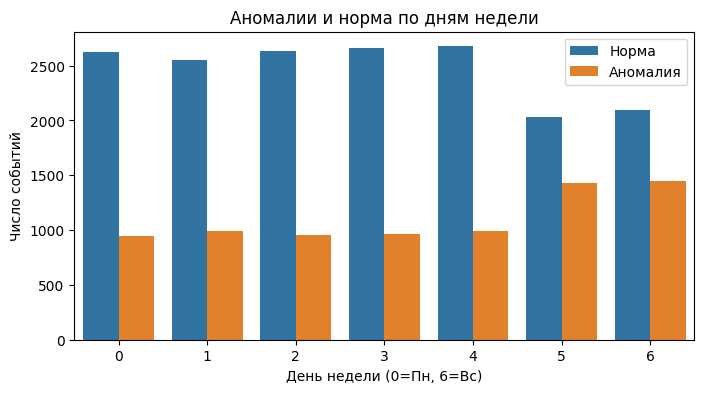

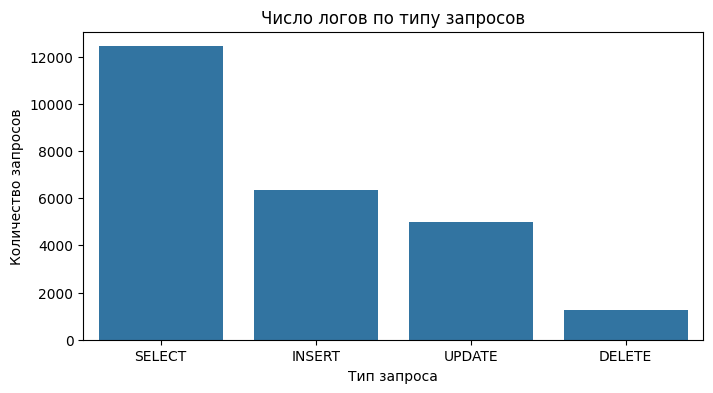

In [2]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='day_of_week', hue='is_anomaly')
plt.title('Аномалии и норма по дням недели')
plt.xlabel('День недели (0=Пн, 6=Вс)')
plt.ylabel('Число событий')
plt.legend( labels=['Норма', 'Аномалия'])
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='query_type')
plt.title('Число логов по типу запросов')
plt.xlabel('Тип запроса')
plt.ylabel('Количество запросов')
plt.show()



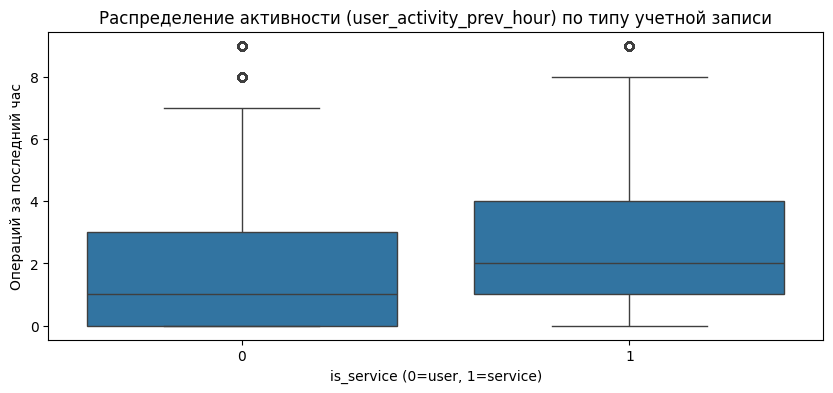

In [3]:
plt.figure(figsize=(10,4))
sns.boxplot(x='is_service', y='user_activity_prev_hour', data=df)
plt.title('Распределение активности (user_activity_prev_hour) по типу учетной записи')
plt.xlabel('is_service (0=user, 1=service)')
plt.ylabel('Операций за последний час')
plt.show()

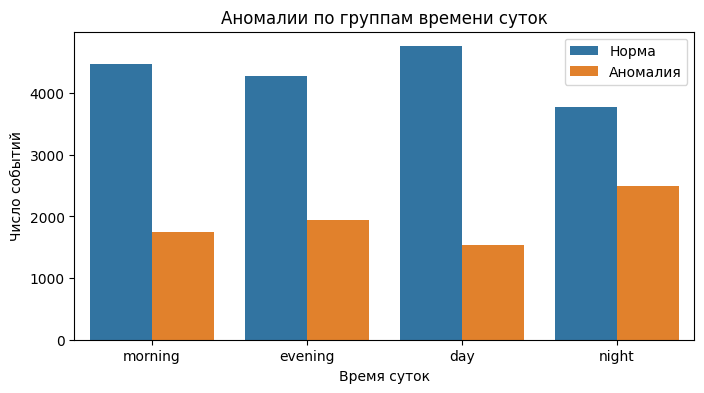

In [4]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='hour_group', hue='is_anomaly')
plt.title('Аномалии по группам времени суток')
plt.xlabel('Время суток')
plt.ylabel('Число событий')
plt.legend(labels=['Норма', 'Аномалия'])
plt.show()

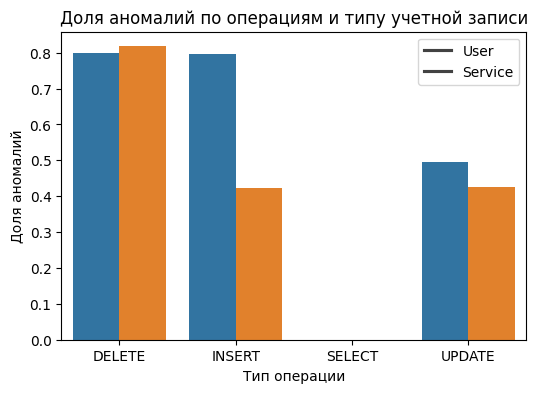

In [5]:
anom_share = df.groupby(['query_type','is_service'])['is_anomaly'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=anom_share, x='query_type', y='is_anomaly', hue='is_service')
plt.title('Доля аномалий по операциям и типу учетной записи')
plt.ylabel('Доля аномалий')
plt.xlabel('Тип операции')
plt.legend(labels=['User', 'Service'])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = ['is_service','query_type','hour_group']
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cats = encoder.fit_transform(df[cat_cols])

X_nums = df[['hour','day_of_week','user_activity_prev_hour']].values

X = np.hstack([X_cats, X_nums])
y = df['is_anomaly'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_scaled, y, df, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)

Train shape: (20005, 10)


In [7]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(n_estimators=200, contamination=np.mean(y_train), random_state=42)
iso.fit(X_train)
y_pred_score = -iso.decision_function(X_test)
y_pred = (iso.predict(X_test) == -1).astype(int)

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test)
y_rf_proba = rf.predict_proba(X_test)[:,1]

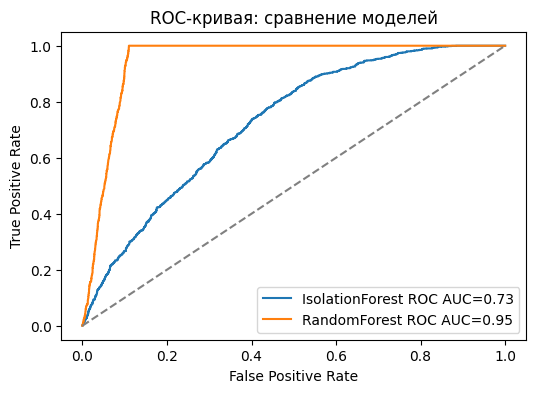

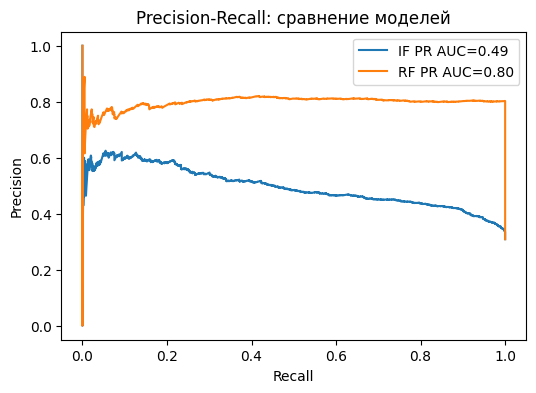

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Isolation Forest ROC/PR
fpr_if, tpr_if, _ = roc_curve(y_test, y_pred_score)
precision_if, recall_if, _ = precision_recall_curve(y_test, y_pred_score)
roc_auc_if = auc(fpr_if, tpr_if)
pr_auc_if = auc(recall_if, precision_if)

# Random Forest ROC/PR
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_proba)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)
pr_auc_rf = auc(recall_rf, precision_rf)


plt.figure(figsize=(6,4))
plt.plot(fpr_if, tpr_if, label=f'IsolationForest ROC AUC={roc_auc_if:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest ROC AUC={roc_auc_rf:.2f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('ROC-кривая: сравнение моделей')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(recall_if, precision_if, label=f'IF PR AUC={pr_auc_if:.2f}')
plt.plot(recall_rf, precision_rf, label=f'RF PR AUC={pr_auc_rf:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall: сравнение моделей')
plt.legend()
plt.show()

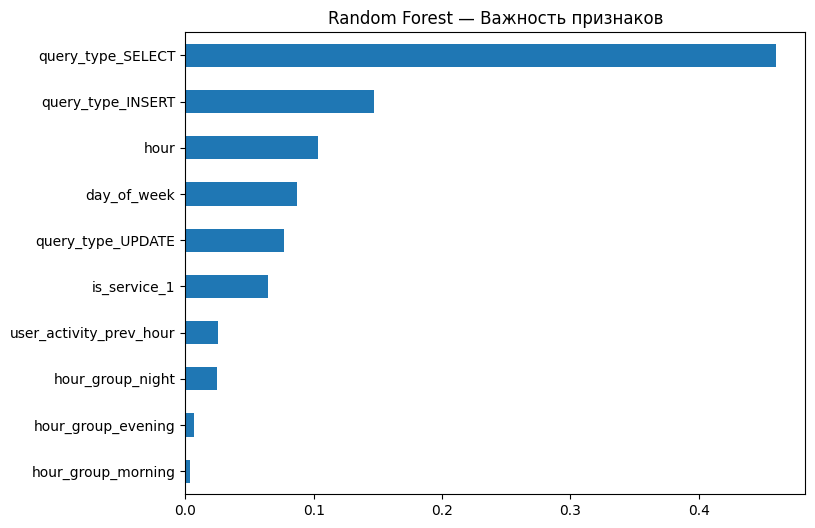

In [10]:


if hasattr(rf, "feature_importances_"):
    imp = pd.Series(rf.feature_importances_, 
                    index=(list(encoder.get_feature_names_out(cat_cols)) + ['hour','day_of_week','user_activity_prev_hour']))
    imp.sort_values().plot(kind="barh", figsize=(8,6), title="Random Forest — Важность признаков")
    plt.show()

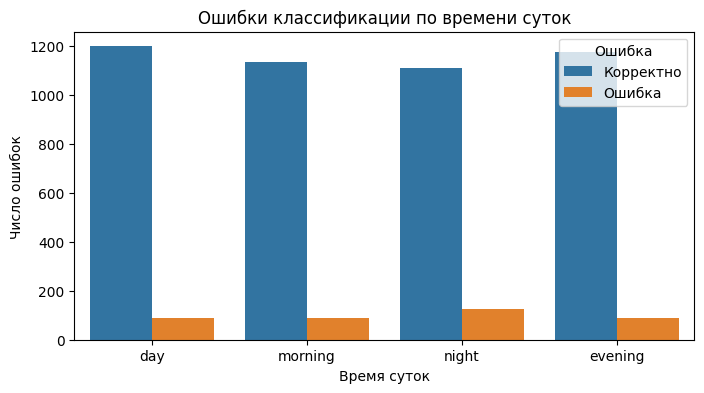

In [11]:
df_test['pred_is_anomaly'] = y_rf_pred

plt.figure(figsize=(8,4))
sns.countplot(data=df_test, x='hour_group', hue=(df_test['is_anomaly'] != df_test['pred_is_anomaly']))
plt.title('Ошибки классификации по времени суток')
plt.xlabel('Время суток')
plt.ylabel('Число ошибок')
plt.legend(title='Ошибка', labels=['Корректно', 'Ошибка'])
plt.show()